In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import networkx as nx
from scipy.spatial import distance
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
import scipy as sp
from scipy.linalg import fractional_matrix_power
from scipy import linalg
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans


Each entry contains the data aquired from the chemical analysis of some type of wine. Wines belong in 3 categories which are considered unknown in this excersize and will only be used for the validation of results.

In [2]:
data=pd.read_csv('C:/Users/John/Documents/Business mathematics/Summer School/Βασσάλος/wines.csv')

In [3]:
data.head()

,Region,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
data['Region'].value_counts()

2    71
1    59
3    48
Name: Region, dtype: int64

In [5]:
I=np.identity(len(data))

Create a copy of the data

In [6]:
data_copy=data.copy(deep=True)

Drop Label 'Region' since it is considered unknown.

In [7]:
data=data.drop('Region',axis=1)

In [8]:
data.shape

(178, 13)

Create a scatter plot of the data to see if we can distinguish any number of clusters

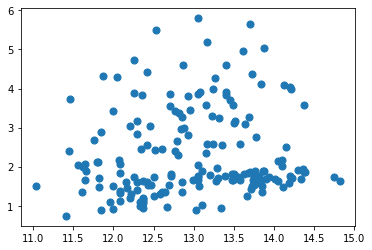

In [9]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1],s=50)#, cmap='viridis')

No apparent clusters can be seen.

Consutruct similarity matrix using knn (k=10)

Compute the (weighted) graph of k-Neighbors for points in X. (mode='distance' returns the standard Euclidean distance)

The below function checks if the input matrix is symmetric

In [10]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

The below function returns the degree matrix of the input graph

In [11]:
def degree_matrix(graph):
    return np.diag(np.sum(graph, axis=1))

Using the KNN graph we create the M-KNN (mutual-KNN) graph which is a subset of the corresponding KNN graph.
The steps to generate the M-KNN are the following:
1)Create the KNN graph (which is an nxn matrix which is directed i.e not symmetrical)
2)In order to create the MUKNN graph we use the above KNN graph. If 2 vertices vij and vji are both within the 10 closest neigbours (e.g. if vij==vji==1)then we connect the two.
(basically what this means is that both are mutualy the closest neighbors of one another).
3)if condition (2) is not true the we set both vij and vji to zero (we dont connect the vertices)

#In the below KNN graph we use the mode:'connectivity' which returns 1 if two vertices are connected and 0 if not.
#The reason for using this mode insted of 'distance' which returns the pairwise Euclidean distance of vertices, is because connectivity is usually implemented and also because there was not such a suggestion in the excercise.  

In [12]:
A = kneighbors_graph(data, n_neighbors=10, mode="connectivity",include_self=False).toarray()

In [13]:
#Create the undirected mutual KNN graph

for i in range(len(A)):
 for j in range(len(A)):
    if A[i,j]==A[j,i]==1:
        pass
    elif A[i,j]!=A[j,i]:
        A[i,j]=0
        A[j,i]=0


In [14]:
check_symmetric(A)

True

Create the degree matrix

In [15]:
D=degree_matrix(A)

In [16]:
D

array([[ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 10.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  8.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 10.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 10.]])

Create the unnormalized Laplacian matrix

In [17]:
L=D-A

In [18]:
D1=fractional_matrix_power(D, -1)

Normalized Laplacian : L_rw=I-D^(-1)*A=D^(-1)*A

In [19]:
L_rw=np.matmul(D1,L)

In [20]:
L_rw

array([[ 1.        , -0.14285714,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1       ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.125     ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.1       ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

Get the eigenvalues of the Laplacian matrix by solving the generalized eigenproblem Lu=λDu

In [21]:
w,u=sp.sparse.linalg.eigs(L_rw,k=3,which='SM',M=D)#,sigma=0)

In [22]:
w=np.real(np.round(w,4))

since we want to use 3 clusters we will use the 3 smallest eigenvectors

In [23]:
u=np.real(np.round(u,3))

U_new contains the vectors u1,....,uk as columns

In [24]:
u_new=u[:,:3]

We implement kmeams to cluster the rows of u_new

In [25]:
kmeans = KMeans(n_clusters=3,random_state=1).fit(u_new)

Get the labels from the created clusters

In [26]:
label=kmeans.labels_

Get the centers of the created clusters

In [27]:
centers = kmeans.cluster_centers_

Plot the original data using the colored labels 

Text(0.5, 1.0, 'Original data with colored labels')

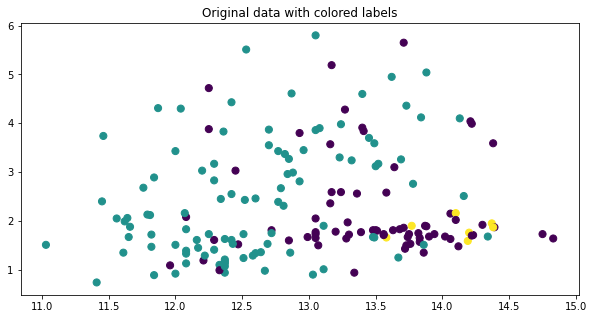

In [28]:
plt.figure(figsize=(10,5))
#plt.scatter(u_new[label==0][:,0], u_new[label==0][:,1], c=label, s=50, cmap='viridis')
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=label, s=50, cmap='viridis')
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('Original data with colored labels')

Plot the original data using the colored labels ( in 3D)

Text(0.5, 0.92, 'Original data with colored labels in 3D')

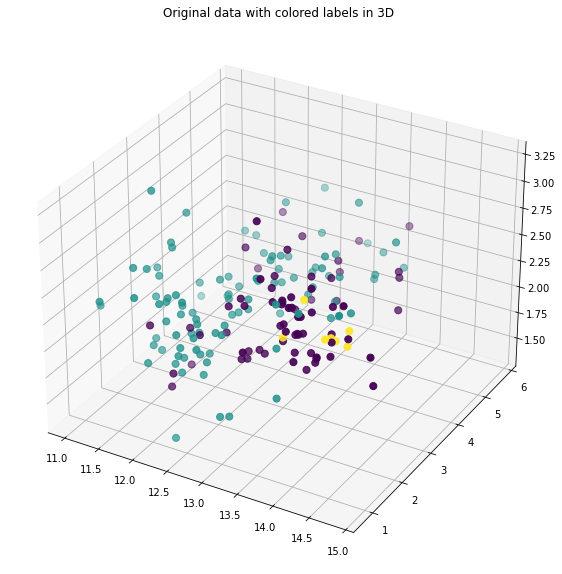

In [29]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.scatter(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],c=label,s=50)
plt.title('Original data with colored labels in 3D')


Plot the eigenvectors and the cluster centers using the colored labels

Text(0.5, 1.0, 'Eigenvectors with labels')

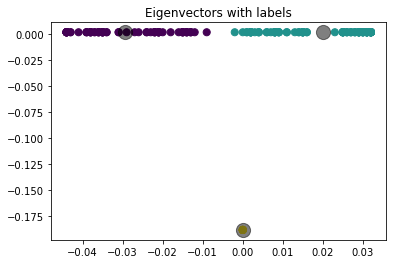

In [30]:
plt.scatter(u_new[:,0], u_new[:, 1], c=label, s=50, cmap='viridis')
#plt.scatter(u_new[:,1], u_new[:, 2], c=label, s=50, cmap='viridis')
#plt.scatter(u_new[:,1], u_new[:, 2], c=label, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Eigenvectors with labels')

It is evident that there are three distinct clusters

In [31]:
kmeans=kmeans.predict(u_new)

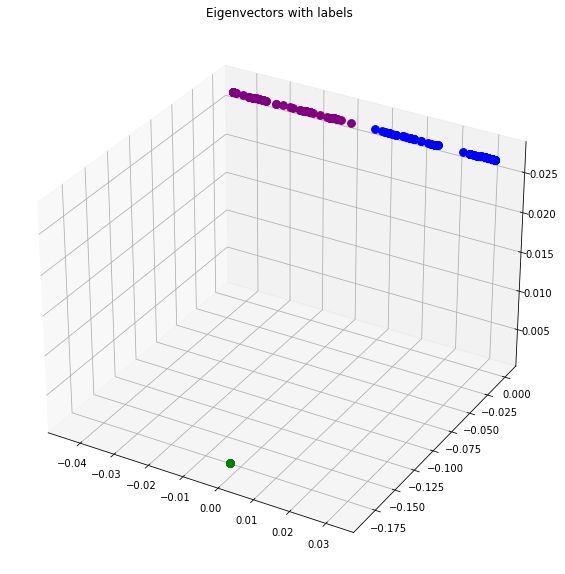

In [32]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
plt.title('Eigenvectors with labels')
for i in range(178):
    if kmeans[i]==0:
        ax.scatter(u_new[i,0],u_new[i,1],u_new[i,2],c='purple',s=60)
    elif kmeans[i]==1:
        ax.scatter(u_new[i,0],u_new[i,1],u_new[i,2],c='blue',s=60)
    elif kmeans[i]==2:
        ax.scatter(u_new[i,0],u_new[i,1],u_new[i,2],c='green',s=60)

The number of clusters can be clearly distinguished

Based on the information of column 1 in the original dataset (wine categories), we create the contigency matrix

In [33]:
label_0 = data[label == 0]
label_1 = data[label == 1]
label_2 = data[label == 2]

Original categories were 1,2,3 so subtract 1 to make the correspond to the created cluster labels

In [34]:
data_copy['Region']=data_copy['Region']-1

In [35]:
data_copy['Region']

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: Region, Length: 178, dtype: int64

The contigency matrix is given below

In [37]:
sk.metrics.cluster.contingency_matrix(data_copy['Region'],label)

array([[51,  1,  7],
       [ 9, 62,  0],
       [11, 37,  0]], dtype=int64)